In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

In [2]:
mi.set_variant('cuda_ad_rgb')
from mitsuba import ScalarTransform4f as T


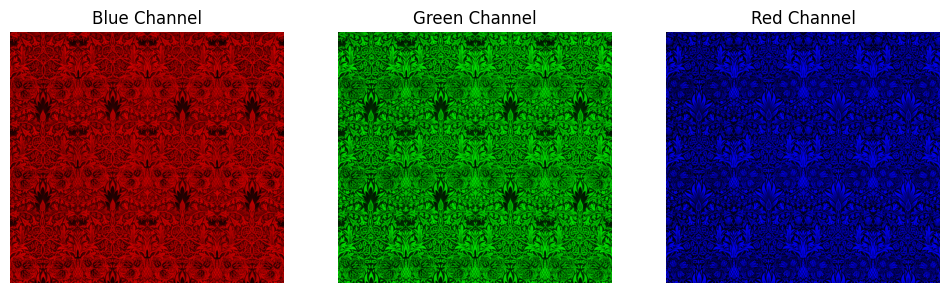

True

In [18]:
image = cv2.imread('Scene_Data/textures/wallpaper.jpg', cv2.COLOR_BGR2RGB)
zeros = np.zeros(image.shape[:2], dtype = "uint8")

# Split the image into RGB channels
blue_channel = cv2.merge([image[:, :, 0], zeros, zeros])
green_channel = cv2.merge([zeros, image[:, :, 1], zeros])
red_channel = cv2.merge([zeros, zeros, image[:, :, 2]])

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display the blue channel
axs[0].imshow(blue_channel)
axs[0].set_title('Blue Channel')

# Display the green channel
axs[1].imshow(green_channel)
axs[1].set_title('Green Channel')

# Display the red channel
axs[2].imshow(red_channel)
axs[2].set_title('Red Channel')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Show the subplots
plt.show()

# Save the blue channel as a texture
cv2.imwrite('Scene_Data/textures/blue_wallpaper.jpg', blue_channel)

# Save the green channel as a texture
cv2.imwrite('Scene_Data/textures/green_wallpaper.jpg', green_channel)

# Save the red channel as a texture
cv2.imwrite('Scene_Data/textures/red_wallpaper.jpg', red_channel)


In [3]:
scene_both = mi.load_file("Scene_Data/cbox_lego_both.xml")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


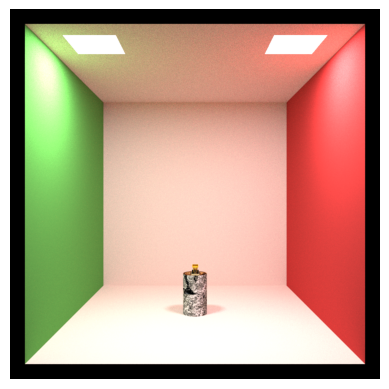

In [19]:
scene_both = mi.load_file("Scene_Data/cbox_lego_both.xml")
view_both = mi.render(scene_both, spp=128)
mi.Bitmap(view_both).write('both.exr')
both = cv2.imread('both.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

plt.axis("off")
plt.imshow(cv2.cvtColor(both** (1.0/2.2), cv2.COLOR_BGR2RGB))


In [ ]:
# params = mi.traverse(scene_both)
# print(params)


In [ ]:
# print(params['cylindertex.brdf_0.reflectance.data'])

In [26]:
tree = ET.parse("Scene_Data/cbox_lego_both.xml")
root = tree.getroot()
for bsdf in root.iter('bsdf'):
    # Check if the bsdf type is 'diffuse' and id is 'cylindif'
    if bsdf.attrib.get('type') == 'diffuse' and bsdf.attrib.get('id') == 'cylindif':
        # Within the BSDF element, find the texture element with the attribute type="bitmap"
        for texture in bsdf.iter('texture'):
            if texture.attrib.get('name') == 'reflectance':
                # Change the filename attribute of the bitmap texture to the new texture file
                for string in texture.iter('string'):
                    if string.attrib.get('name') == 'filename':
                        string.set('value', 'textures/wood.jpg')

tree.write('Scene_Data/cbox_lego_both.xml')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 1023.5, -0.5)

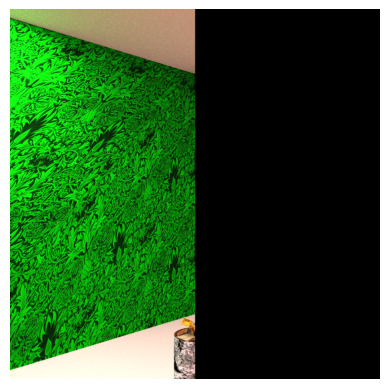

In [39]:
scene_bothn = mi.load_file("Scene_Data/cbox_lego_both.xml")
view_bothn = mi.render(scene_bothn, spp=128)
bothn = plt.imshow(view_bothn** (1.0 / 2.2))

plt.axis("off")
# plt.imshow(cv2.cvtColor(both** (1.0/2.2), cv2.COLOR_BGR2RGB))

In [ ]:
scene_left = mi.load_file("Scene_Data/cbox_left.xml")
view_left = mi.render(scene_left, spp=1024)
mi.Bitmap(view_left).write('left.exr')
left = cv2.imread('left.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

plt.axis("off")
plt.imshow(cv2.cvtColor(left** (1.0/2.2), cv2.COLOR_BGR2RGB))

In [ ]:
scene_right = mi.load_file("Scene_Data/cbox_right.xml")
view_right = mi.render(scene_right, spp=1024)
mi.Bitmap(view_right).write('right.exr')
right = cv2.imread('right.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

plt.axis("off")
plt.imshow(cv2.cvtColor(right** (1.0/2.2), cv2.COLOR_BGR2RGB))


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(cv2.cvtColor(both**(1.0/2.2), cv2.COLOR_BGR2RGB))
axs[0].set_title("both lights are on")

axs[1].imshow(cv2.cvtColor(left**(1.0/2.2), cv2.COLOR_BGR2RGB))
axs[1].set_title("left light is on")

axs[2].imshow(cv2.cvtColor(right**(1.0/2.2), cv2.COLOR_BGR2RGB))
axs[2].set_title("right light is on")

plt.show()


In [6]:
def load_sensor(r, theta, phi, pts):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = pts + T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])
    # target = pt+ T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, 0])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 39.37,
        'to_world': T.look_at(
            origin=origin,
            target=pts,
            up=[0, 1, 0]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 1024,
            'height': 1024,
            'rfilter': {
                'type': 'tent',
            },
            'pixel_format': 'rgb',
        },
    })

In [5]:
radius = 6
phis = [22.5*(i+1) for i in range(16)]
thetas = [22.5*(j+1) for j in range(16)]
# thetas = [90]
pts = [[0,-9.5,0]]

sensors = []
for pt in pts:
    for phi in phis:
        for theta in thetas:
            sensors.append(load_sensor(radius,theta,phi, pt))
sensor_count = len(sensors)

In [ ]:
# lookat_ys = [-10]
# ys=[-10, -5]
# xs=[-10, -5, -3, 0, 3, 5, 10]
# zs=[-10, -5, -3, 0, 3, 5, 10]
# sensors = []
# for lookat_y in lookat_ys:
#     for y in ys:
#         for z in zs:
#             for x in xs:
#                 sensors.append(load_sensor(x,y,z, lookat_y))
# sensor_count = len(sensors)

In [6]:
sensor_count

256

In [7]:
current_dir = os.getcwd()

In [8]:
current_dir

'/home/sa11799x/Documents/Thesis_Aryaman/Mitsuba_scene_creation'

both image


In [9]:
scene_both = mi.load_file("Scene_Data/cbox_both.xml")
images_both = [mi.render(scene_both, spp=1024, sensor=sensor) for sensor in sensors]



2024-03-28 14:50:39 WARN main [integrator_v.cpp:32] Received interrupt signal, winding down..

KeyboardInterrupt: 

In [ ]:
num_images = len(images_both)
batch_size = 64
num_batches = num_images // batch_size

for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size

    fig = plt.figure(figsize=(16, 18))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i, image_index in enumerate(range(start_index, end_index)):
        ax = fig.add_subplot(4, 8, i + 1)
        ax.imshow(images_both[image_index] ** (1.0 / 2.2))
        plt.axis("off")

    plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8* int(len(sensors) / 4)))
fig.subplots_adjust(wspace=0, hspace=0)
h = 1
for row in range(4):
    for col in range(2):
        index = col * 4 + row+1
        ax = fig.add_subplot(4,2, h)
        ax.imshow(images_both[index - 1] ** (1.0 / 2.2))
        plt.axis("off")
        h += 1

plt.show()

In [ ]:
folder_name = current_dir+"/Data/both/files_EXR"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    phi_value = phis[i // len(thetas)]
    theta_value = thetas[i % len(thetas)]
    file_name_exr = f"{phi_value}_{theta_value}.exr"
    file_path_exr = os.path.join(folder_name, file_name_exr)
    mi.Bitmap(images_both[i]).write(file_name_exr)
    # mi.util.write_bitmap(file_path_exr, images_both[i])
    # print(i,file_name_exr, file_path_exr)
os.chdir(current_dir)    



In [ ]:
folder_name = current_dir+"/Data/Dragon/rad6/files_PNG"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    phi_value = phis[i % len(phis)]
    theta_value = thetas[i // len(phis)]
    file_name_png = f"{phi_value}_{theta_value}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_both[i])
    os.chdir(current_dir)
os.chdir(current_dir)    


right image:

In [ ]:
images_right = [mi.render(scene_right, spp=1024, sensor=sensor) for sensor in sensors]

In [ ]:
fig1 = plt.figure(figsize=(10,15))
fig1.subplots_adjust(wspace=0, hspace=0)
for i in range(50):
    ax = fig1.add_subplot(10, 5, i + 1).imshow(images_right[i] ** (1.0 / 2.2))
    plt.axis("off")
plt.show()

fig2 = plt.figure(figsize=(10,15))
fig2.subplots_adjust(wspace=0, hspace=0)
for i in range(50, 100):
    ax = fig2.add_subplot(10, 5, i + 1 - 50).imshow(images_right[i] ** (1.0 / 2.2))
    plt.axis("off")
plt.show()

In [ ]:
folder_name = current_dir+"/Data/right/files_EXR"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    phi_value = phis[i // len(thetas)]
    theta_value = thetas[i % len(thetas)]
    file_name_exr = f"{phi_value}_{theta_value}.exr"
    file_path_exr = os.path.join(folder_name, file_name_exr)
    mi.Bitmap(images_right[i]).write(file_name_exr)
    # print(i,file_name_exr, file_path_exr)
os.chdir(current_dir)    


In [ ]:
folder_name = current_dir+"/Data/Manual_cart/right/files_PNG"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    lookat_y = lookat_ys[i // (len(xs) * len(zs) * len(ys))]
    x = xs[(i // len(zs)) % len(xs)]
    y = ys[(i // len(zs)) % len(ys)]
    z = zs[i % len(zs)]
    file_name_png = f"{lookat_y}_{x}_{y}_{z}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_right[i])
os.chdir(current_dir)    


In [ ]:
images_left = [mi.render(scene_left, spp=1024, sensor=sensor) for sensor in sensors]


In [ ]:
fig1 = plt.figure(figsize=(10,15))
fig1.subplots_adjust(wspace=0, hspace=0)
for i in range(50):
    ax = fig1.add_subplot(10, 5, i + 1).imshow(images_left[i] ** (1.0 / 2.2))
    plt.axis("off")
plt.show()

fig2 = plt.figure(figsize=(10,15))
fig2.subplots_adjust(wspace=0, hspace=0)
for i in range(50, 100):
    ax = fig2.add_subplot(10, 5, i + 1 - 50).imshow(images_left[i] ** (1.0 / 2.2))
    plt.axis("off")
plt.show()

In [ ]:
folder_name = current_dir+"/Data/Manual_cart/left/files_EXR"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    phi_value = phis[i // len(thetas)]
    theta_value = thetas[i % len(thetas)]
    file_name_exr = f"{phi_value}_{theta_value}.exr"
    file_path_exr = os.path.join(folder_name, file_name_exr)
    mi.Bitmap(images_left[i]).write(file_name_exr)
    # print(i,file_name_exr, file_path_exr)
os.chdir(current_dir)    


In [ ]:
folder_name = current_dir+"/Data/left/files_PNG"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    lookat_y = lookat_ys[i // (len(xs) * len(zs) * len(ys))]
    x = xs[(i // len(zs)) % len(xs)]
    y = ys[(i // len(zs)) % len(ys)]
    z = zs[i % len(zs)]
    file_name_png = f"{lookat_y}_{x}_{y}_{z}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_left[i])
os.chdir(current_dir)    
